# Import Libraries

In [22]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

# Loading and Preparing Data

In [23]:
def load_and_prepare_data(excel_path):
    df = pd.read_csv(excel_path)
    # Strip whitespace from Course Code
    df['Course Code'] = df['Course Code'].str.strip()
    df['Original_Year'] = df['Year']
    df['Year'] = pd.to_datetime(df['Year'].astype(str) + '-01-01')
    return df

# Creating Prophet Forecast

In [24]:
def create_prophet_forecast(data, course_code, forecast_years=7):
    """Improved forecasting with more conservative growth predictions"""
    prophet_df = data.rename(columns={'Year': 'ds', 'Enrollment': 'y'})
    
    # Calculate recent trend (last 3 years)
    recent_growth = prophet_df['y'].tail(3).pct_change().mean()
    
    # Calculate overall trend
    overall_growth = prophet_df['y'].pct_change().mean()
    
    # Use a weighted average of recent and overall growth to avoid extreme predictions
    weighted_growth = (recent_growth * 0.7 + overall_growth * 0.3)
    
    # Dampen the growth rate for more conservative predictions
    dampening_factor = 0.5
    weighted_growth = weighted_growth * dampening_factor
    
    # Set course-specific bounds
    historical_max = prophet_df['y'].max()
    historical_min = prophet_df['y'].min()
    current_value = prophet_df['y'].iloc[-1]
    
    if course_code == 'GRAND_TOTAL':
        # More conservative bounds for total enrollment
        cap = min(historical_max * 1.15, current_value * 1.2)
        floor = max(historical_min * 0.95, current_value * 0.8)
    else:
        # Individual course bounds - more conservative
        if weighted_growth > 0:
            cap = min(historical_max * 1.25, current_value * 1.3)
            floor = max(historical_min * 0.9, current_value * 0.75)
        else:
            cap = min(historical_max * 1.1, current_value * 1.15)
            floor = max(historical_min * 0.95, current_value * 0.85)
    
    prophet_df['cap'] = cap
    prophet_df['floor'] = floor
    
    # Define changepoints with more recent data points
    changepoints = pd.date_range(
        start=prophet_df['ds'].min(),
        end=prophet_df['ds'].max(),
        freq='YS'
    )
    
    model = Prophet(
        growth='logistic',
        changepoint_prior_scale=0.0005,  # Reduced for smoother predictions
        seasonality_prior_scale=0.001,
        changepoint_range=0.95,
        interval_width=0.85,  # Wider confidence intervals
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoints=changepoints
    )
    
    model.fit(prophet_df)
    
    # Calculate exact periods needed to reach 2029
    last_year = prophet_df['ds'].dt.year.max()
    periods_needed = 2029 - last_year
    
    future_dates = model.make_future_dataframe(periods=periods_needed, freq='Y')
    future_dates['cap'] = cap
    future_dates['floor'] = floor
    
    forecast = model.predict(future_dates)
    
    # Apply more conservative post-processing
    forecast['yhat'] = forecast['yhat'].clip(lower=floor, upper=cap)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=floor)
    forecast['yhat_upper'] = forecast['yhat_upper'].clip(upper=cap)
    
    # Future predictions processing
    future_mask = forecast['ds'].dt.year > last_year
    if not forecast[future_mask].empty:
        # Apply logarithmic growth instead of linear
        years_out = np.array(range(1, len(forecast[future_mask]) + 1))
        growth_factor = np.log1p(years_out * abs(weighted_growth)) * np.sign(weighted_growth)
        base_value = forecast.loc[~future_mask, 'yhat'].iloc[-1]
        
        forecast.loc[future_mask, 'yhat'] = base_value * (1 + growth_factor)
        
        # Ensure predictions stay within bounds
        forecast['yhat'] = forecast['yhat'].clip(lower=floor, upper=cap)
    
    # Smooth the transitions
    forecast['yhat'] = forecast['yhat'].ewm(span=3, adjust=False).mean()
    
    # Convert dates back to years
    forecast['year'] = forecast['ds'].dt.year
    
    return forecast

# Forecasting All Courses

In [25]:
def forecast_all_courses(df):
    forecasts = {}
    
    # First forecast GRAND_TOTAL
    total_data = df[df['Course Code'] == 'GRAND_TOTAL'].copy()
    if not total_data.empty:
        forecasts['GRAND_TOTAL'] = create_prophet_forecast(total_data, 'GRAND_TOTAL')
    
    # Then forecast individual courses
    courses = df[df['Course Code'] != 'GRAND_TOTAL']['Course Code'].unique()
    for course in courses:
        try:
            course_data = df[df['Course Code'] == course].copy()
            if len(course_data) >= 3:
                forecast = create_prophet_forecast(course_data, course)
                forecasts[course] = forecast
        except Exception as e:
            print(f"Error forecasting course {course}: {str(e)}")
    
    return forecasts

# Plotting Forecast

In [26]:
def plot_forecasts(forecasts, actual_data):
    # Set style
    plt.style.available
    
    # First plot GRAND_TOTAL
    if 'GRAND_TOTAL' in forecasts:
        _plot_single_forecast('GRAND_TOTAL', forecasts['GRAND_TOTAL'], actual_data, is_total=True)
    
    # Then plot other courses
    for course in sorted(forecasts.keys()):
        if course != 'GRAND_TOTAL':
            _plot_single_forecast(course, forecasts[course], actual_data, is_total=False)

def _plot_single_forecast(course, forecast, actual_data, is_total=False):
    plt.figure(figsize=(12, 6))
    
    # Plot actual values
    actual = actual_data[actual_data['Course Code'] == course]
    plt.plot(actual['Original_Year'], actual['Enrollment'], 
             'ko-', label='Historical', markersize=8, linewidth=2)
    
    # Plot forecast
    future_mask = forecast['year'] > 2022
    
    # Historical fitted values
    plt.plot(forecast[~future_mask]['year'], forecast[~future_mask]['yhat'],
             'b--', label='Fitted', alpha=0.6, linewidth=2)
    
    # Future predictions
    plt.plot(forecast[future_mask]['year'], forecast[future_mask]['yhat'],
             'b-', label='Forecast', linewidth=2)
    
    # Confidence intervals for future predictions only
    plt.fill_between(
        forecast[future_mask]['year'],
        forecast[future_mask]['yhat_lower'],
        forecast[future_mask]['yhat_upper'],
        color='blue', alpha=0.1,
        label='80% Confidence Interval'
    )
    
    # Annotate future points
    for year, value in zip(forecast[future_mask]['year'], forecast[future_mask]['yhat']):
        plt.annotate(
            f'{int(round(value))}',
            (year, value),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center',
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.7)
        )
    
    title = 'Total Enrollment Forecast' if is_total else f'Enrollment Forecast for {course}'
    plt.title(title, pad=20, fontsize=14, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Enrollment', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Improve x-axis
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
    plt.xticks(rotation=45)
    
    # Set y-axis to start from 0
    ymax = max(actual['Enrollment'].max() * 1.2, forecast[future_mask]['yhat_upper'].max() * 1.1)
    plt.ylim(bottom=0, top=ymax)
    
    plt.tight_layout()
    plt.show()

# Forecast Summary

In [27]:
def create_forecast_summary(forecasts):
    summary = {}
    
    for course, forecast in forecasts.items():
        # Get the future predictions (excluding historical dates)
        current_year = datetime.now().year
        future_forecast = forecast[forecast['year'] > current_year]
        
        summary[course] = {
            'Years': future_forecast['year'].values,
            'Predicted_Values': future_forecast['yhat'].values,
            'Lower_Bound': future_forecast['yhat_lower'].values,
            'Upper_Bound': future_forecast['yhat_upper'].values
        }
    
    return summary

# Main Function

19:41:19 - cmdstanpy - INFO - Chain [1] start processing
19:41:28 - cmdstanpy - INFO - Chain [1] done processing
19:41:28 - cmdstanpy - INFO - Chain [1] start processing
19:41:30 - cmdstanpy - INFO - Chain [1] done processing
19:41:31 - cmdstanpy - INFO - Chain [1] start processing
19:41:31 - cmdstanpy - INFO - Chain [1] done processing
19:41:31 - cmdstanpy - INFO - Chain [1] start processing
19:41:31 - cmdstanpy - INFO - Chain [1] done processing
19:41:31 - cmdstanpy - INFO - Chain [1] start processing
19:41:33 - cmdstanpy - INFO - Chain [1] done processing
19:41:33 - cmdstanpy - INFO - Chain [1] start processing
19:41:33 - cmdstanpy - INFO - Chain [1] done processing
19:41:33 - cmdstanpy - INFO - Chain [1] start processing
19:41:35 - cmdstanpy - INFO - Chain [1] done processing
19:41:35 - cmdstanpy - INFO - Chain [1] start processing
19:41:41 - cmdstanpy - INFO - Chain [1] done processing
19:41:41 - cmdstanpy - INFO - Chain [1] start processing
19:41:50 - cmdstanpy - INFO - Chain [1]


Forecast Summary for GRAND_TOTAL:
  Year   | Predicted Value | Lower Bound | Upper Bound
  ---------------------------------------------
  2025  | 3902.80        | 3312.80     | 4617.96
  2026  | 4070.09        | 3312.80     | 4688.30
  2027  | 4236.08        | 3312.80     | 4536.10
  2028  | 4397.70        | 3312.80     | 4568.48

Forecast Summary for BEED:
  Year   | Predicted Value | Lower Bound | Upper Bound
  ---------------------------------------------
  2025  | 195.72        | 144.00     | 249.60
  2026  | 204.47        | 144.00     | 249.60
  2027  | 213.14        | 144.00     | 249.60
  2028  | 221.56        | 144.00     | 249.60

Forecast Summary for BSA:
  Year   | Predicted Value | Lower Bound | Upper Bound
  ---------------------------------------------
  2025  | 389.51        | 298.50     | 517.40
  2026  | 414.90        | 298.50     | 517.40
  2027  | 439.23        | 298.50     | 517.40
  2028  | 462.25        | 298.50     | 517.40

Forecast Summary for BSBA:
  Year   

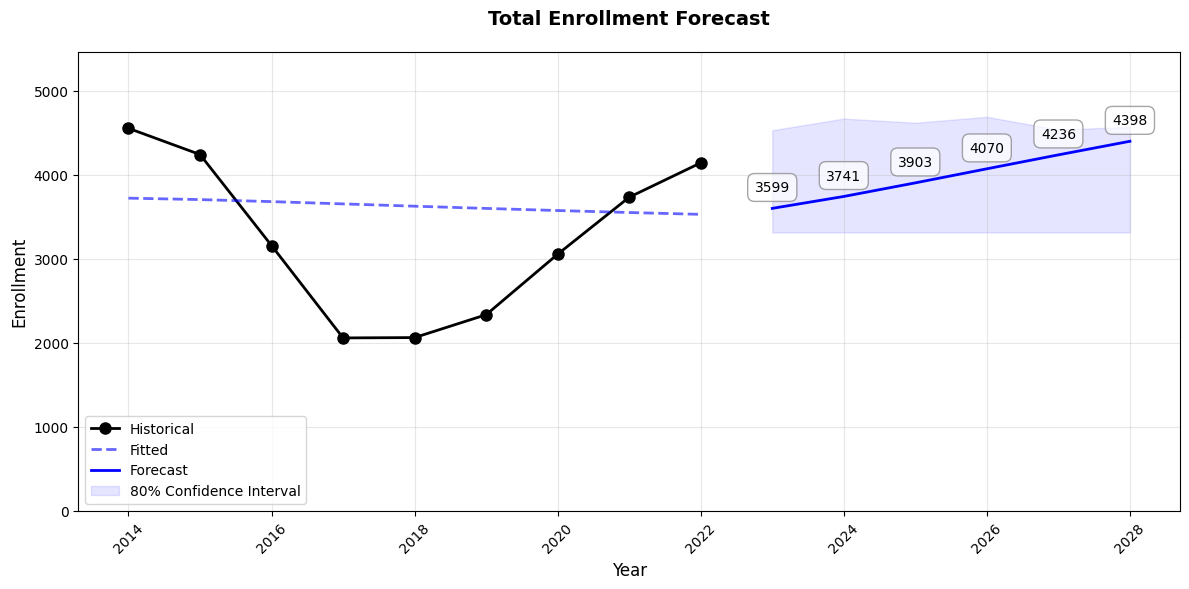

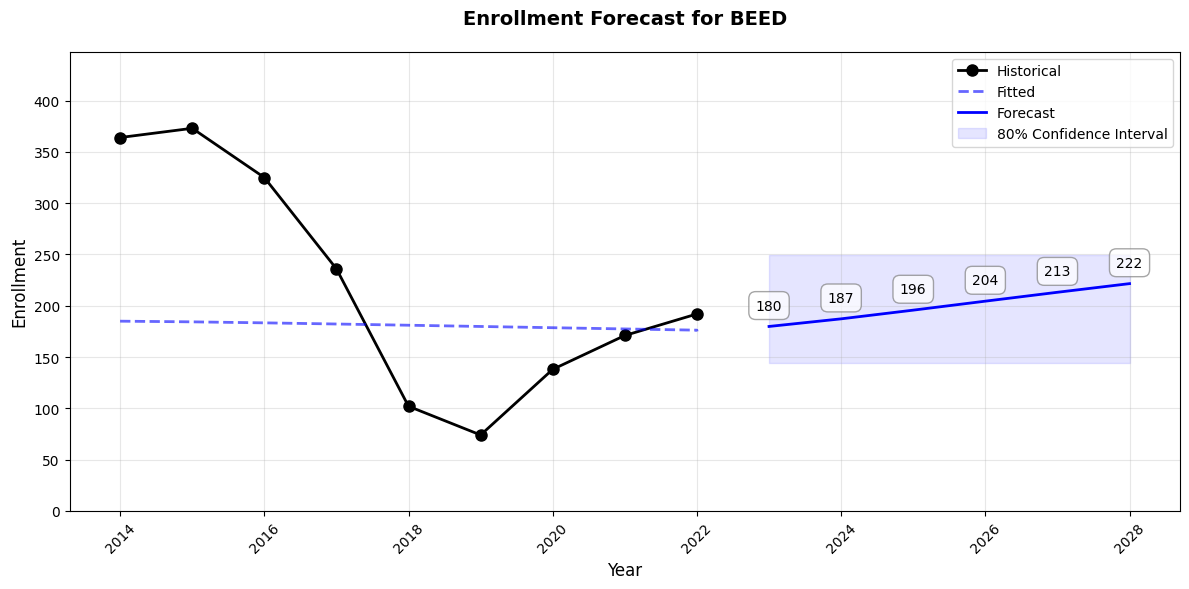

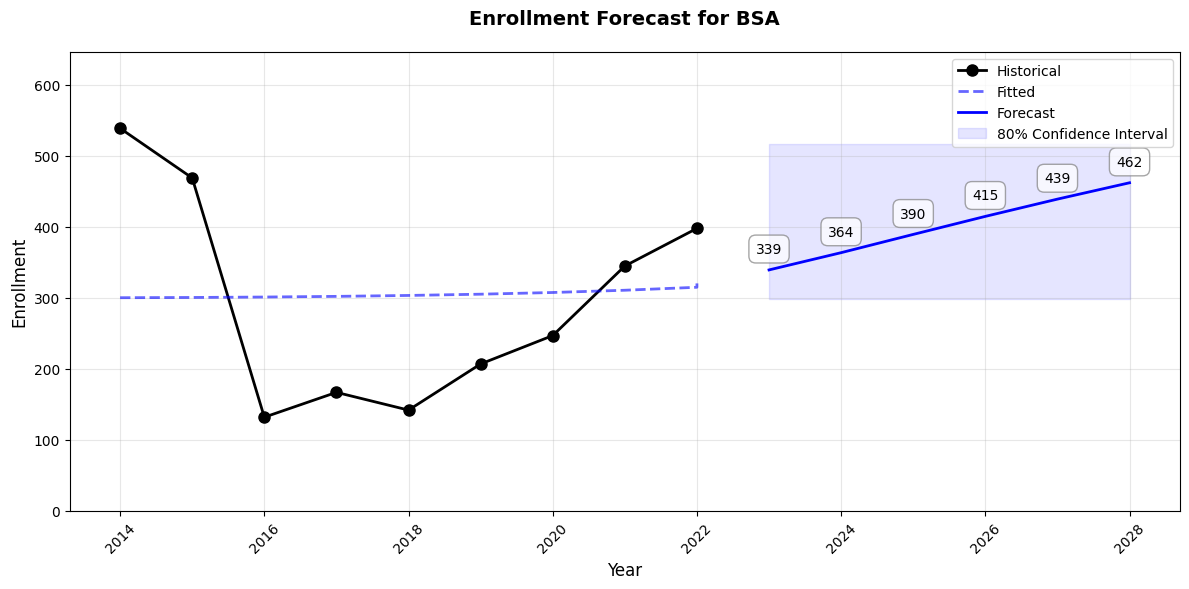

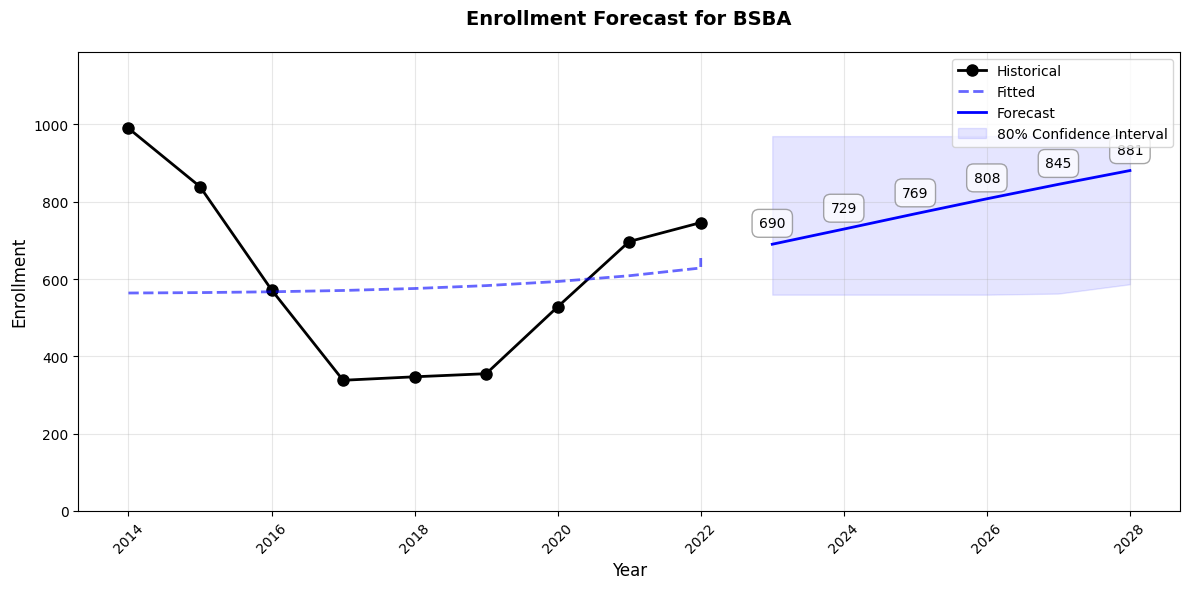

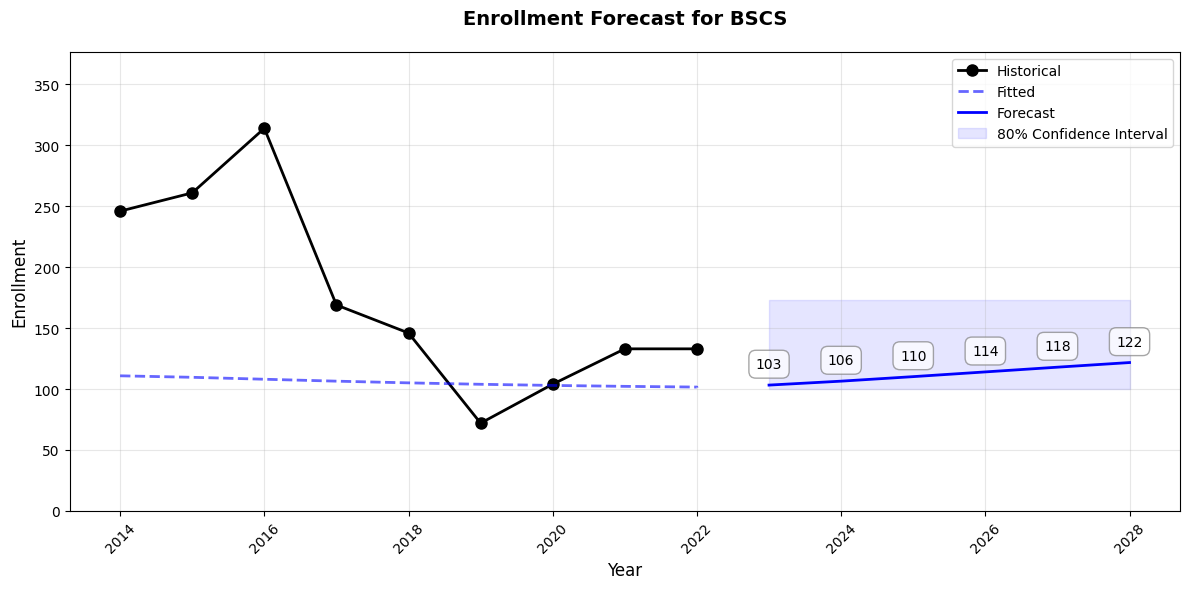

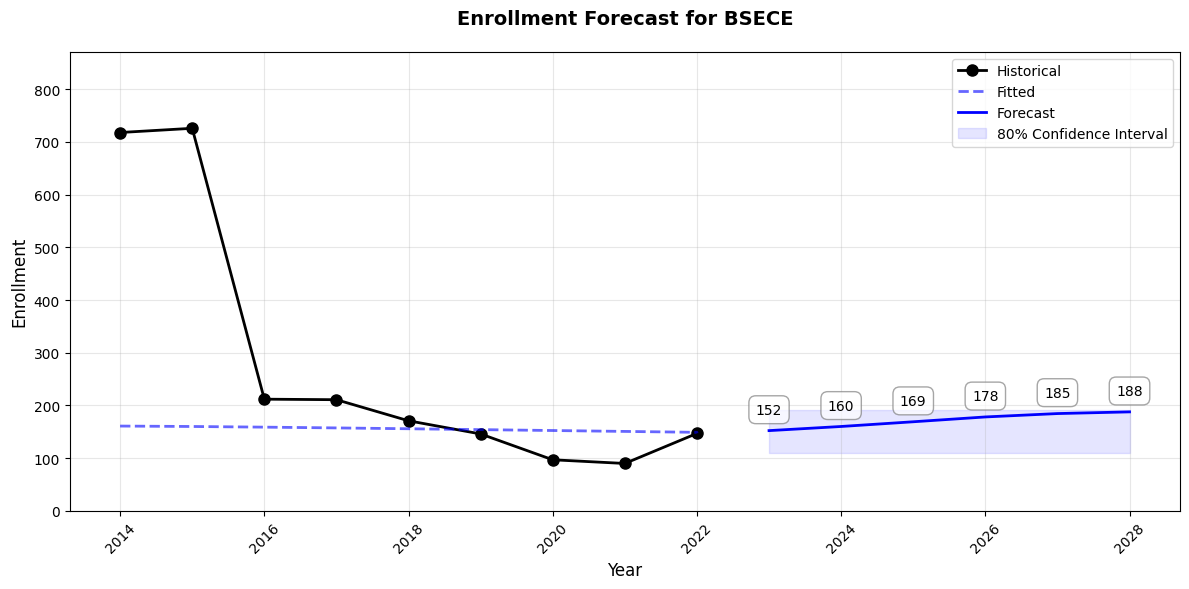

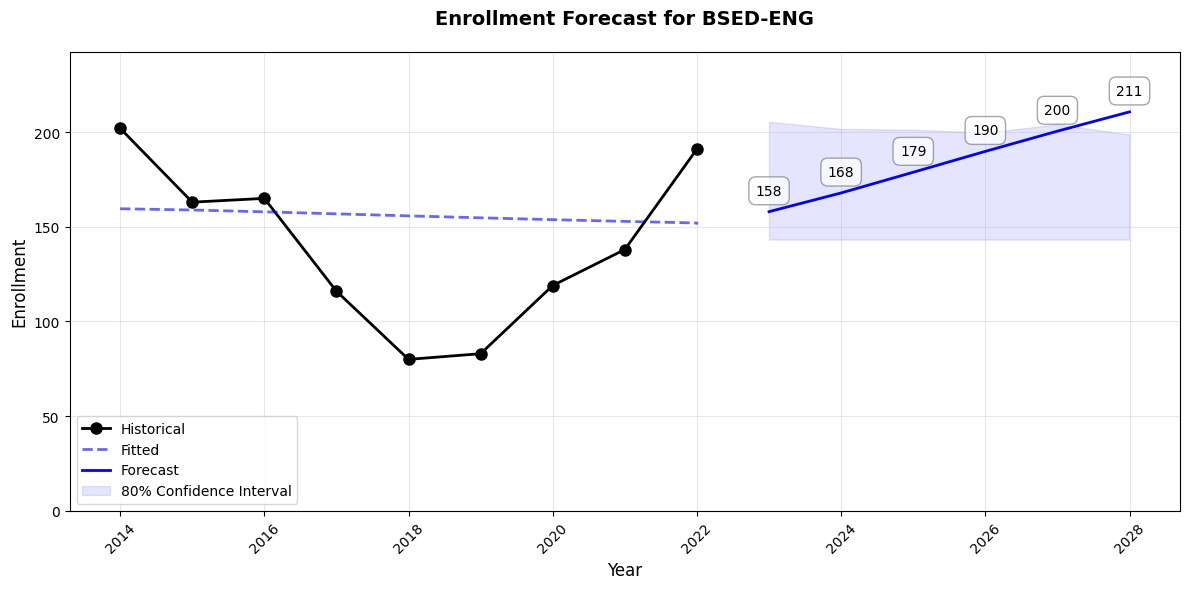

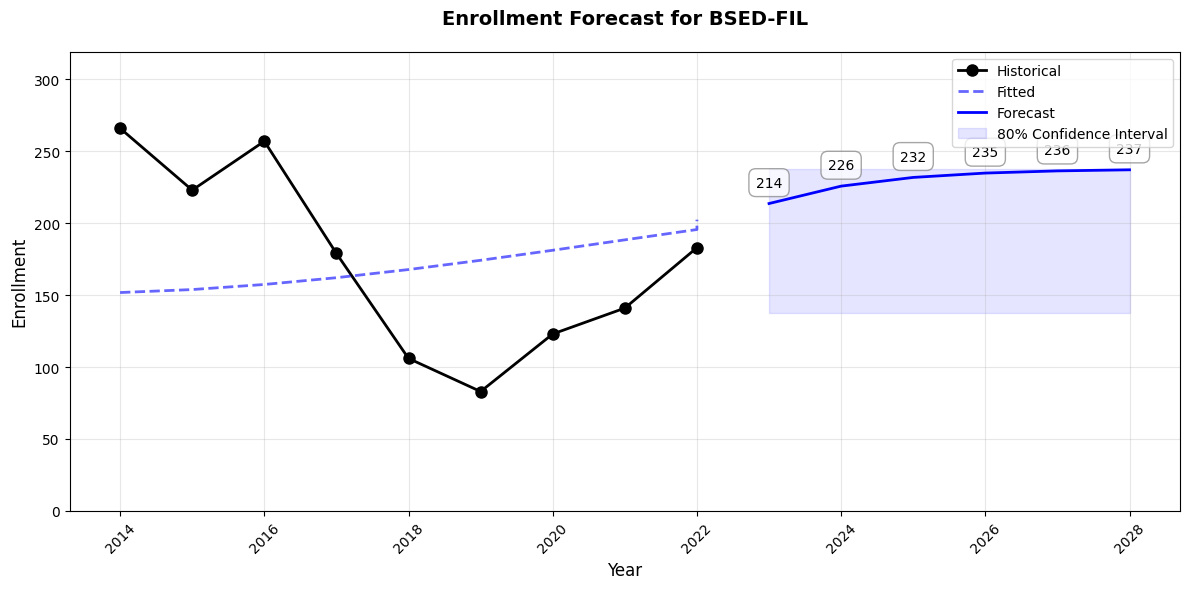

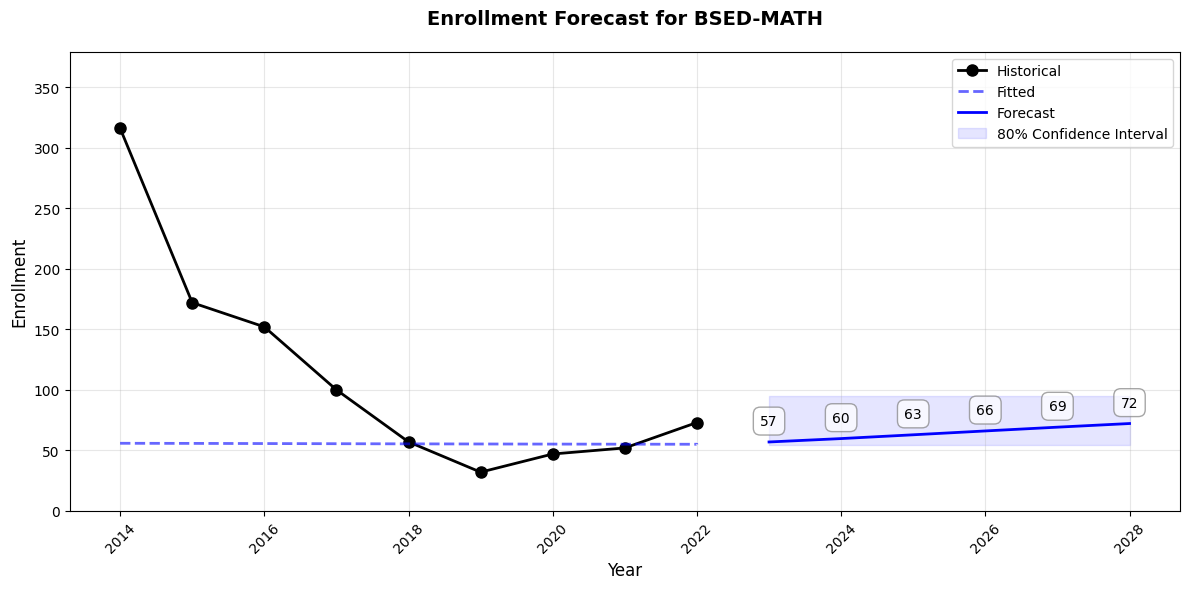

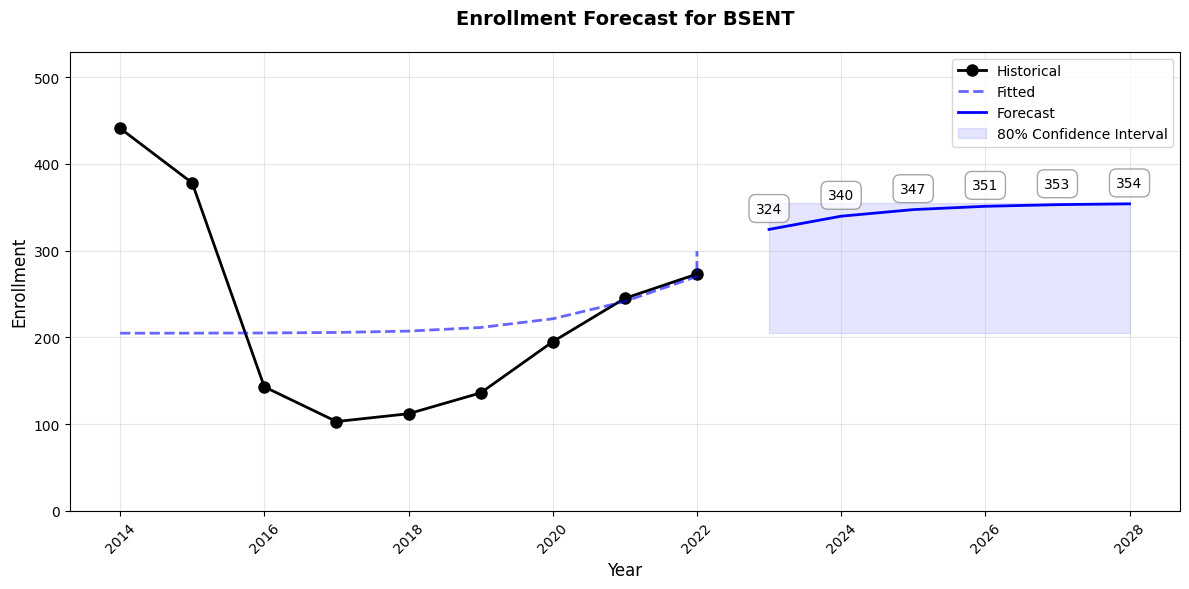

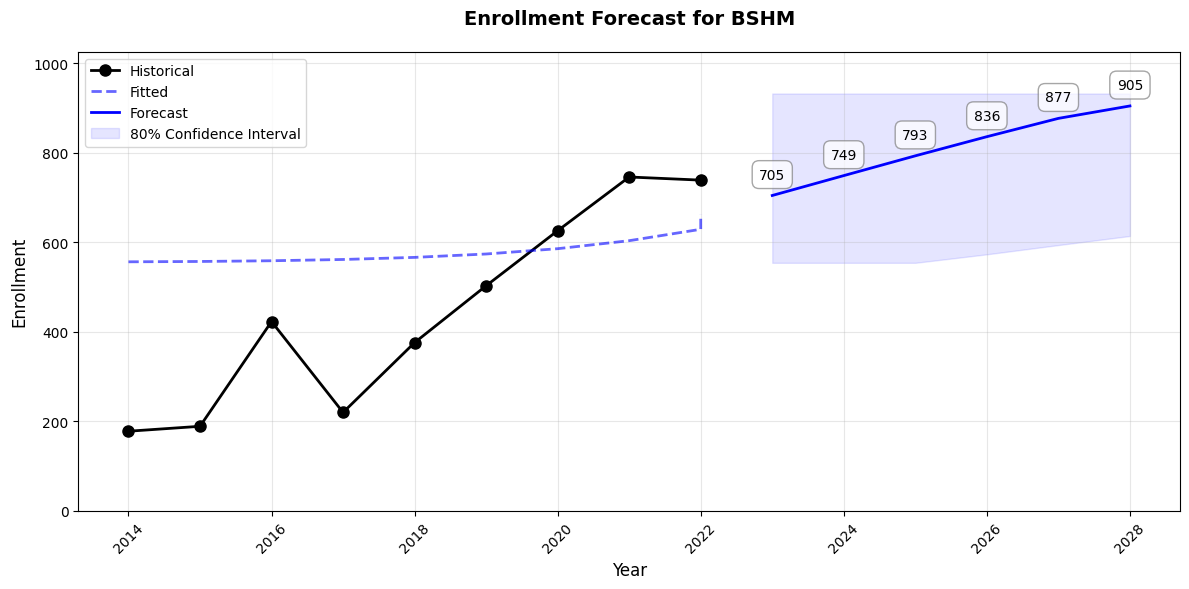

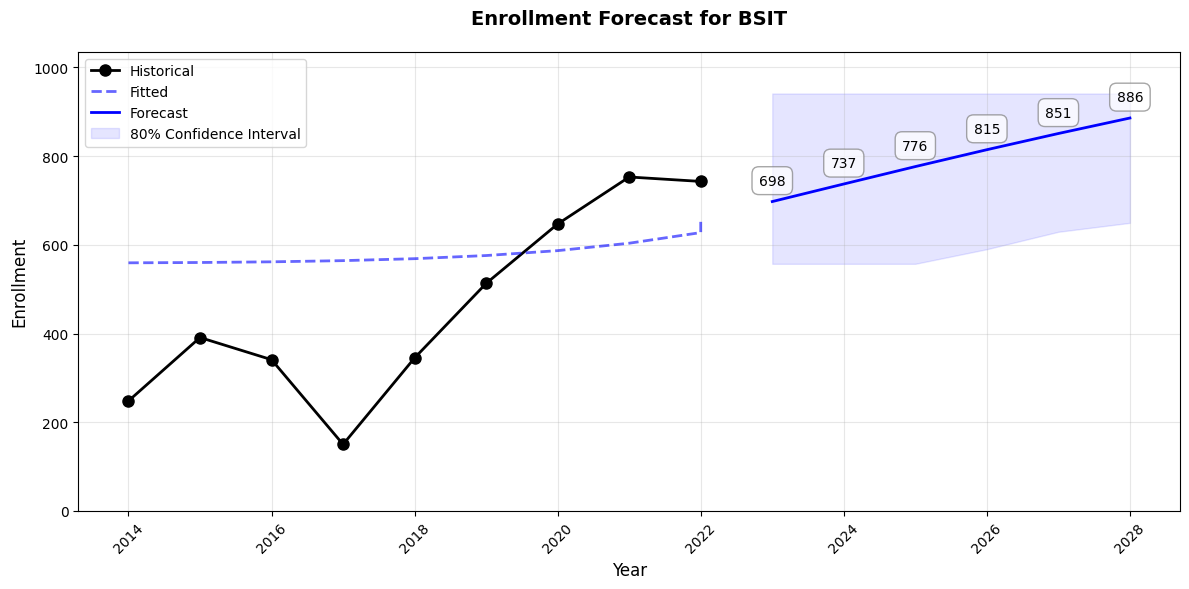

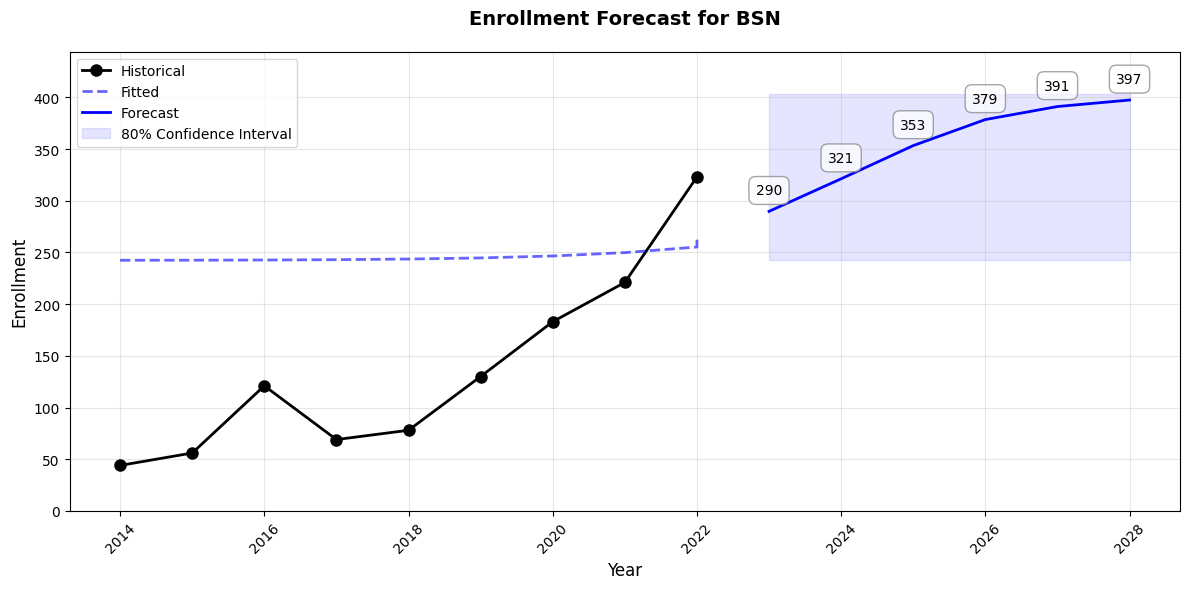

In [28]:
def main():
    excel_path = r'C:\Users\acer\Desktop\plp-enrollment-insights-dashboardd\src\lib\ml\data\EnrollmentData.csv'
    df = load_and_prepare_data(excel_path)
    forecasts = forecast_all_courses(df)

    # Create and print a more readable summary
    summary = create_forecast_summary(forecasts)
    for course, details in summary.items():
        print(f"\nForecast Summary for {course}:")
        print("  Year   | Predicted Value | Lower Bound | Upper Bound")
        print("  " + "-" * 45)
        for year, predicted, lower, upper in zip(details['Years'], details['Predicted_Values'], details['Lower_Bound'], details['Upper_Bound']):
            print(f"  {year}  | {predicted:.2f}        | {lower:.2f}     | {upper:.2f}")

    plot_forecasts(forecasts, df)

if __name__ == "__main__":
    main()